## Import some helpful libraries

In [3]:
## Import some helpful libraries
print("    Version control\n------------------------")
import os, fnmatch, random, math, sys, datetime
from pathlib import Path
import numpy as np;              print("Numpy\t\t", np.__version__)
import matplotlib as mpl;        print("matplotlib\t", mpl.__version__)
import matplotlib.pyplot as plt
import nibabel as nib;           print("NiBabel\t\t {}".format(nib.__version__))
from nibabel.testing import data_path
import pandas as pd;             print("Pandas\t\t {}".format(pd.__version__))
import imageio;                  print("imageio\t\t {}".format(imageio.__version__))
import h5py;                     print("H5py\t\t {}".format(h5py.__version__))
import sklearn;                  print("Scikit-learn\t {}".format(sklearn.__version__))
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
import skimage;                  print("Scikit-image\t {}".format(skimage.__version__))
import tensorflow as tf;         print("TensorFlow\t {}".format(tf.__version__))
import keras;                    print("Keras\t\t {}".format(keras.__version__))
import tensorflow.keras.backend as K
from tensorflow.keras import models, Input, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape, BatchNormalization, Conv3D, MaxPooling3D, UpSampling3D, ZeroPadding3D
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.initializers import *
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.engine.topology import Layer, InputSpec
from keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from IPython.display import Image
# %load_ext tensorboard       
# %reload_ext tensorboard

    Version control
------------------------
Numpy		 1.19.4
matplotlib	 3.3.3
NiBabel		 3.2.0
Pandas		 1.1.4
imageio		 2.9.0
H5py		 2.10.0
Scikit-learn	 0.23.2
Scikit-image	 0.17.2
TensorFlow	 2.4.0
Keras		 2.4.3


## Dataset

In [2]:
## Load train data
sample_train_subset = np.loadtxt(('./Data/data_random_1/sample_train.csv'), dtype=str, delimiter=",")
train_data = np.load('./Data/data_random_1/train.npy').reshape(100,182,218,182,1)
print('train_data shape is {}'.format(train_data.shape))

## Load Validation data
sample_val_subset = np.loadtxt(('./Data/data_random_1/sample_valid.csv'), dtype=str, delimiter=",")
valid_data = np.load('./Data/data_random_1/valid.npy').reshape(24,182,218,182,1)
print('valid_data shape is {}'.format(valid_data.shape))

train_data shape is (100, 182, 218, 182, 1)
valid_data shape is (24, 182, 218, 182, 1)


In [3]:
## Show the list of files
# print("There are", len(sample_train_subset), " subset of train samples are:\n")
# print(*sample_train_subset, sep='\t')
# print("\n--------------------------------------------------------------------------------\n")
# print("There are", len(sample_val_subset), " subset of Validation samples are:\n")
# print(*sample_val_subset, sep='\t')

In [4]:
## Padding datasets
train_pad_data = (ZeroPadding3D(padding=(5,19,5))(train_data)).numpy()
print('train_padded_data shape is {}'.format(train_pad_data.shape))
valid_pad_data = (ZeroPadding3D(padding=(5,19,5))(valid_data)).numpy()
print('valid_padded_data shape is {}'.format(valid_pad_data.shape))

train_padded_data shape is (100, 192, 256, 192, 1)
valid_padded_data shape is (24, 192, 256, 192, 1)


## Showing slices

In [5]:
## Main Function
def show_slices(slices):
    fig, axes = plt.subplots(1, len(slices), figsize=(10,5))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="hot", origin="upper") # hot, Greys, gray

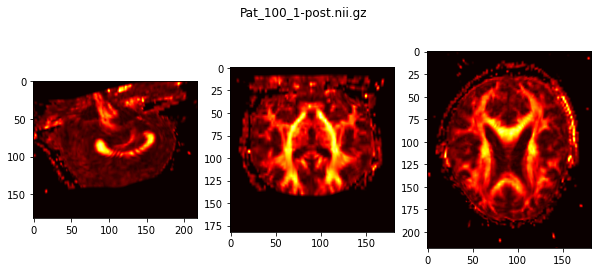

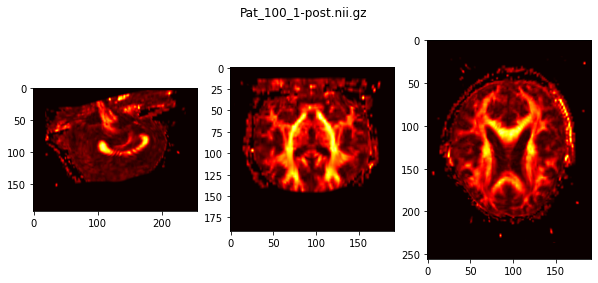

In [6]:
## Showing Original Train samples
for m in range(1):
    slice_0 = train_data[m, 91, :, :, 0]
    slice_1 = train_data[m, :, 109, :, 0]
    slice_2 = train_data[m, :, :, 91, 0]
    show_slices([slice_0, slice_1, slice_2])
    plt.suptitle(sample_train_subset[m], x=0.5, y=0.9)

## Showing Padded Train samples
for m in range(1):
    slice_3 = train_pad_data[m, 96, :, :, 0]
    slice_4 = train_pad_data[m, :, 128, :, 0]
    slice_5 = train_pad_data[m, :, :, 96, 0]
    show_slices([slice_3, slice_4, slice_5])
    plt.suptitle(sample_train_subset[m], x=0.5, y=0.9)

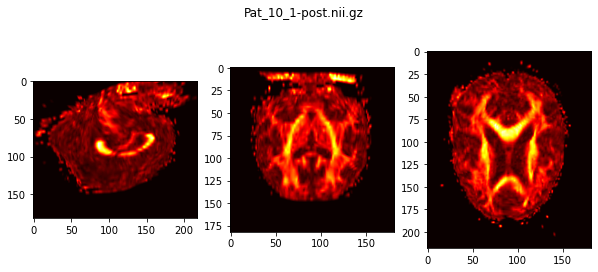

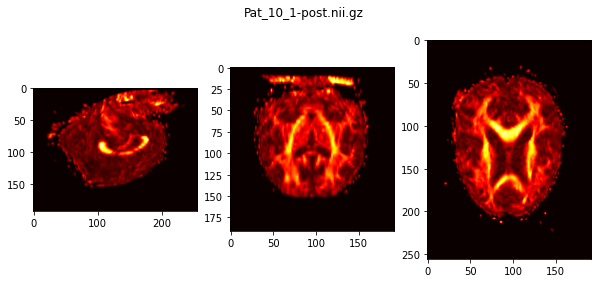

In [7]:
## Showing Original Valid samples
for m in range(1):
    slice_0 = valid_data[m, 91, :, :, 0]
    slice_1 = valid_data[m, :, 109, :, 0]
    slice_2 = valid_data[m, :, :, 91, 0]
    show_slices([slice_0, slice_1, slice_2])
    plt.suptitle(sample_val_subset[m], x=0.5, y=0.9)

## Showing Padded Valid samples
for m in range(1):
    slice_3 = valid_pad_data[m, 96, :, :, 0]
    slice_4 = valid_pad_data[m, :, 128, :, 0]
    slice_5 = valid_pad_data[m, :, :, 96, 0]
    show_slices([slice_3, slice_4, slice_5])
    plt.suptitle(sample_val_subset[m], x=0.5, y=0.9)

## Model design

In [8]:
## Convolutional AutoEncoder Model Designe:

IMAGE_HEIGHT = train_pad_data.shape[1]
IMAGE_WIDTH = train_pad_data.shape[2]
IMAGE_DEPTH = train_pad_data.shape[3]
BATCH_SIZE = 1
EPOCHS = 1
data_shape = [1, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, 1]
input_shape = [BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, 1]
print("Padded data shape: {}\n".format(input_shape))

## Encoder
input_img = Input(shape=(192, 256, 192, 1), name='Input')
x1 = Conv3D(filters=128, kernel_size=3, strides=2, padding='same', activation='relu', name='Conv1')(input_img)
x1 = BatchNormalization(name='BN_Conv1')(x1)
x2 = Conv3D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name='Conv2')(x1)
x2 = BatchNormalization(name='BN_Conv2')(x2)
x3 = Conv3D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name='Conv3')(x2)
x3 = BatchNormalization(name='BN_Conv3')(x3)
x4 = Conv3D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu', name='Conv4')(x3)
x4 = BatchNormalization(name='BN_Conv4')(x4)

## Latent Features
shape_before_flattening = tf.keras.backend.int_shape(x4)
x_LF = Flatten(name='LF')(x4)

##____________________________________________________________________________________________________
# init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')
# # encoded = Dense(50, kernel_initializer=init, activation='relu', name='encoded')(x_LF)
# x_LF = Dense(100, activation='relu', name='encoded')(x_LF)
##____________________________________________________________________________________________________

encoded = x_LF

##____________________________________________________________________________________________________
# x5 = BatchNormalization(name='BN_Dense')(encoded)
# # x5 = Dense(np.prod(shape_before_flattening[1:]), activation='relu', kernel_initializer=init)(encoded)
# x5 = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(x5)
# encoded = x5
##____________________________________________________________________________________________________

x5 = Reshape(shape_before_flattening[1:], name='UnFlat')(encoded)

## Decoder
x5 = Conv3D(filters=16, kernel_size=3, padding='same', activation='relu', name='DeConv3')(x5)
x5 = BatchNormalization(name='BN_DeConv3')(x5)
x5 = UpSampling3D(size=(2, 2, 2), name='UpSampling3')(x5)
x6 = Conv3D(filters=32, kernel_size=3, padding='same', activation='relu', name='DeConv4')(x5)
x6 = BatchNormalization(name='BN_DeConv4')(x6)
x6 = UpSampling3D(size=(2, 2, 2), name='UpSampling4')(x6)
x7 = Conv3D(filters=64, kernel_size=3, padding='same', activation='relu', name='DeConv5')(x6)
x7 = BatchNormalization(name='BN_DeConv5')(x7)
x7 = UpSampling3D(size=(2, 2, 2), name='UpSampling5')(x7)
x8 = Conv3D(filters=128, kernel_size=3, padding='same', activation='relu', name='DeConv6')(x7)
x8 = BatchNormalization(name='BN_DeConv6')(x8)
x8 = UpSampling3D(size=(2, 2, 2), name='UpSampling6')(x8)
decoded = Conv3D(filters=1, kernel_size=3, padding='same', activation='sigmoid', name='Output')(x8)

model_CAE = Model(inputs=input_img, outputs=decoded, name='AutoEncoder')
## optimizer=rmsprop, sgd
model_CAE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_CAE.summary()
# plot_model(model_CAE, to_file='Convolutional_autoencoder_model.png', show_shapes=True)
# Image(filename='Convolutional_autoencoder_model.png')

Padded data shape: [1, 192, 256, 192, 1]

Model: "AutoEncoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 192, 256, 192, 1) 0         
_________________________________________________________________
Conv1 (Conv3D)               (None, 96, 128, 96, 128)  3584      
_________________________________________________________________
BN_Conv1 (BatchNormalization (None, 96, 128, 96, 128)  512       
_________________________________________________________________
Conv2 (Conv3D)               (None, 48, 64, 48, 64)    221248    
_________________________________________________________________
BN_Conv2 (BatchNormalization (None, 48, 64, 48, 64)    256       
_________________________________________________________________
Conv3 (Conv3D)               (None, 24, 32, 24, 32)    55328     
_________________________________________________________________
BN_Conv3 (Bat

## Model training

In [14]:
## Start time:
from datetime import datetime
start_time = datetime.now().strftime("%Y_%m_%d___%H_%M"); print("\nStart Time =", start_time, "\n")

## Model Fit
# model_CAE.load_weights('./Weights/P4_36864___2021_01_04___08_03.hdf5', by_name=True)  # epochs 1-50
# model_CAE.load_weights('./Weights/P4_36864___2021_01_04___13_14.hdf5', by_name=True)  # epochs 51_100
# model_CAE.load_weights('./Weights/P4_36864___2021_01_04___22_13.hdf5', by_name=True)  # epochs 101_300
# model_CAE.load_weights('./Weights/P4_36864___2021_01_05___08_50.hdf5', by_name=True)  # epochs 301_500
# model_CAE.load_weights('./Weights/P4_36864___2021_01_06___16_55.hdf5', by_name=True)  # epochs 501_1000
model_CAE.load_weights('./Weights/P4_36864___2021_01_07___11_42.hdf5', by_name=True)  # epochs 1001_1500

# model_checkpoint_callback = ModelCheckpoint(('./Check/L1___' + start_time), save_weights_only=True, save_best_only=True, monitor='val_loss', mode='max', verbose=1) 
# tb_callback = TensorBoard(('./Logs/L1___' + start_time), histogram_freq=1)
# # early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
# # model_CAE.fit(train_data[0:10,:], train_data[0:10,:], validation_data=(valid_data, valid_data), epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, callbacks=[tb_callback, model_checkpoint_callback], verbose=1)
# model_CAE.fit(train_pad_data, train_pad_data, validation_data=(valid_pad_data, valid_pad_data), epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, callbacks=[tb_callback, model_checkpoint_callback], verbose=1)
# model_CAE.save_weights('./Weights/L1___' + start_time + '.hdf5')

## End time:
from datetime import datetime
end_time = datetime.now().strftime("%Y_%m_%d___%H_%M"); print("\nEnd Time =", end_time)


Start Time = 2021_01_16___12_44 


End Time = 2021_01_16___12_44


## Image reconstruction

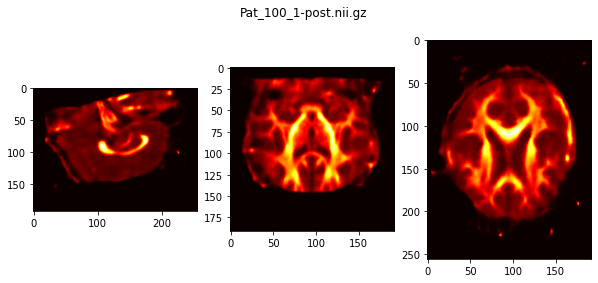

In [15]:
## Reconstructing a Train data 
test_pad_data = train_pad_data[0,:].reshape(1, 192, 256, 192, 1)
# ## Reconstructing a Valid data 
# test_pad_data = valid_pad_data[0,:].reshape(1, 192, 256, 192, 1)

reconstructed = model_CAE.predict(test_pad_data)
for m in range(1):
    slice_0 = reconstructed[m, 96, :, :, 0]
    slice_1 = reconstructed[m, :, 128, :, 0]
    slice_2 = reconstructed[m, :, :, 96, 0]
    show_slices([slice_0, slice_1, slice_2])
    plt.suptitle(sample_train_subset[m], x=0.5, y=0.9)

In [17]:
## Showing some of voxels
print('\ntrain_pad_data[0,96,125:130,96]\n\n {}'.format(train_pad_data[0,96,125:130,96]),'\n')
print('\nReconstructed_data[0,96,125:130,96]\n\n {}'.format(reconstructed[0,96,125:130,96]),'\n')


train_pad_data[0,96,125:130,96]

 [[0.19734716]
 [0.17220303]
 [0.13873336]
 [0.17750186]
 [0.20233598]] 


Reconstructed_data[0,96,125:130,96]

 [[0.17174333]
 [0.15899315]
 [0.15013295]
 [0.14244062]
 [0.14945677]] 



## Weights of model

In [19]:
# ## Weights of Full-Model

# h5_file = h5py.File(('./Weights/P4_36864___2021_01_04___22_13.hdf5'), 'r')

# print(h5_file)
# Layer_size = len(list(h5_file.keys()))
# Layer_names = list(h5_file.keys())
# print("\nThere are", Layer_size, "layers in this model, named as:\n\n", Layer_names,'\n')
# print('====================================================================\n')
# for l in range(12, 13):  # Conv & Deconv (12, 23)
#     layers = h5_file[Layer_names[l]]
#     print("Layer", l+1, "-----", layers)
#     W = layers[Layer_names[l]]['kernel:0']
#     print('Layer', list(h5_file.keys())[l], '\tWeights\' shape: {}'.format(W.shape), '\n')
#     print('\nWeights[0][0][0][0][0]: {}'.format(W[0][0][0][0][0:3]))    # Weights[1][1][1][0][1]
#     print('====================================================================\n')
#     Kernel_1 = W.shape[0]
#     Kernel_2 = W.shape[1]
#     Kernel_3 = W.shape[2]
#     Kernel_all = np.zeros([Kernel_1, Kernel_2, Kernel_3])
#     for f in range(W.shape[4]):   # W.shape[4]
#         for x in range(Kernel_1):
#             for y in range(Kernel_2):
#                 for z in range(Kernel_3):
#                     Kernel_all[x][y][z] = W[x][y][z][0][f]
# #         print('\nWeights of kernel', f+1, 'of', W.shape[4], ':\n\n', Kernel_all)

## LF features

In [21]:
## Encoder model design

model_Encoder = Model(inputs=input_img, outputs=encoded, name='Encoder')
model_Encoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# model_Encoder.summary()
# plot_model(model_Encoder, to_file='Encoder_model.png', show_shapes=True)
# Image(filename='Encoder_model.png')

LF_features size: (36864,) -------- <class 'numpy.ndarray'> 

The first feature is -0.12437891960144043

The LF feature vector is:
[-0.12437892  1.6480687  -0.07434261 ... -0.77945465 -0.48300916
 -0.8795147 ]

(12, 16, 12, 16)


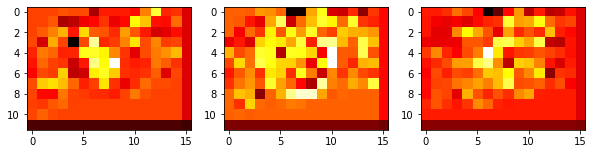

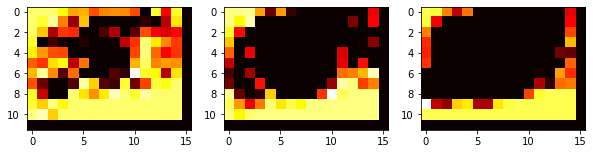

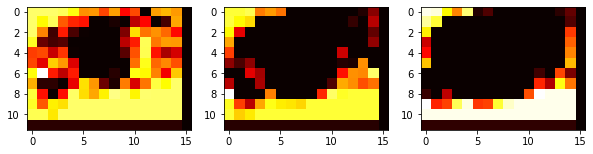

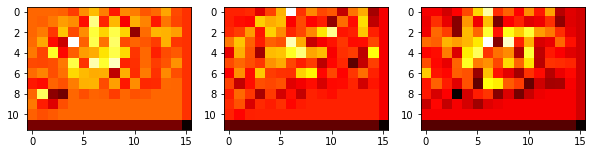

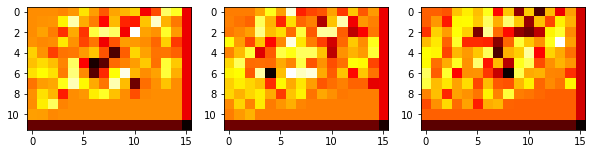

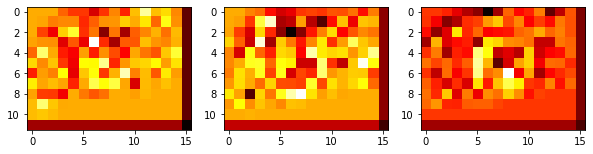

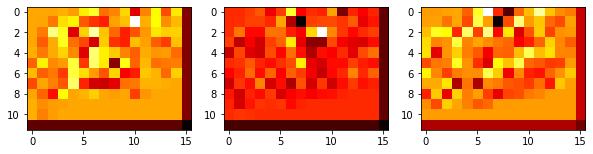

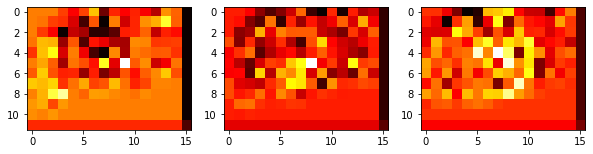

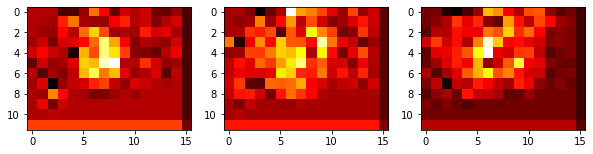

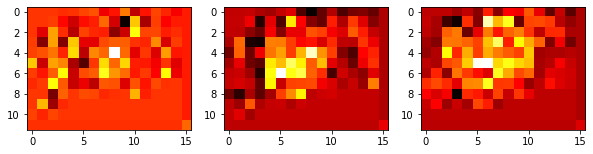

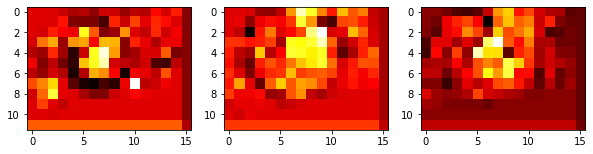

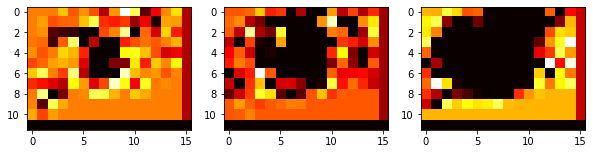

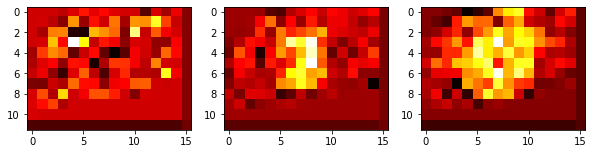

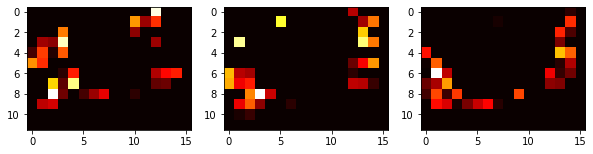

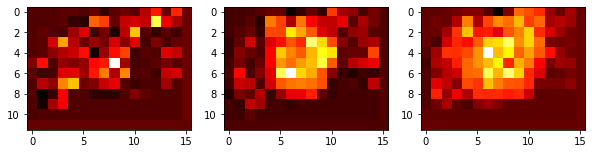

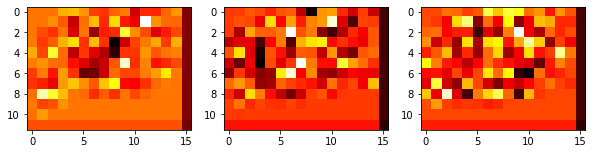

In [23]:
## Showing LF vector for train sample

test_pad_data = train_pad_data[0,:].reshape(1, 192, 256, 192, 1)

LF_features = model_Encoder.predict(test_pad_data)[0]

print('LF_features size: {} -------- {} \n'.format(LF_features.shape, type(LF_features)))
print('The first feature is {}\n'.format(LF_features[0]))
print('The LF feature vector is:\n{}\n'.format(LF_features))

## Showing LF image for train sample
LLL = LF_features.reshape(12,16,12,16)
print(LLL.shape)   #(1, 192, 256, 192, 1)
for m in range(16):
    slice_0 = LLL[0, :, :, m]
    slice_1 = LLL[1, :, :, m]
    slice_2 = LLL[2, :, :, m]
    show_slices([slice_0, slice_1, slice_2])

In [24]:
## Activate TensorBoard

# tensorboard --logdir=Logs       ## http://localhost:6006/

## LF_matrix as a numpy array

In [25]:
# ## Producing and saving LF_matrix as a numpy array

# a = []
# for p in range (len(val_name)):
#     test_pad_data = valid_pad_data[p,:].reshape(1, 192, 256, 192, 1)
#     LF_features = model_Encoder.predict(test_pad_data)[0]
#     a.append(LF_features)
#     print(p)
# for p in range (len(train_name)):
#     test_pad_data = train_pad_data[p,:].reshape(1, 192, 256, 192, 1)
#     LF_features = model_Encoder.predict(test_pad_data)[0]
#     a.append(LF_features)
#     print(p)

# LF_matrix = np.array(a)
# print(LF_matrix.shape)
# print(type(LF_matrix))
# np.save('./Data/LF/LF_e1500', LF_matrix)

## Clustering

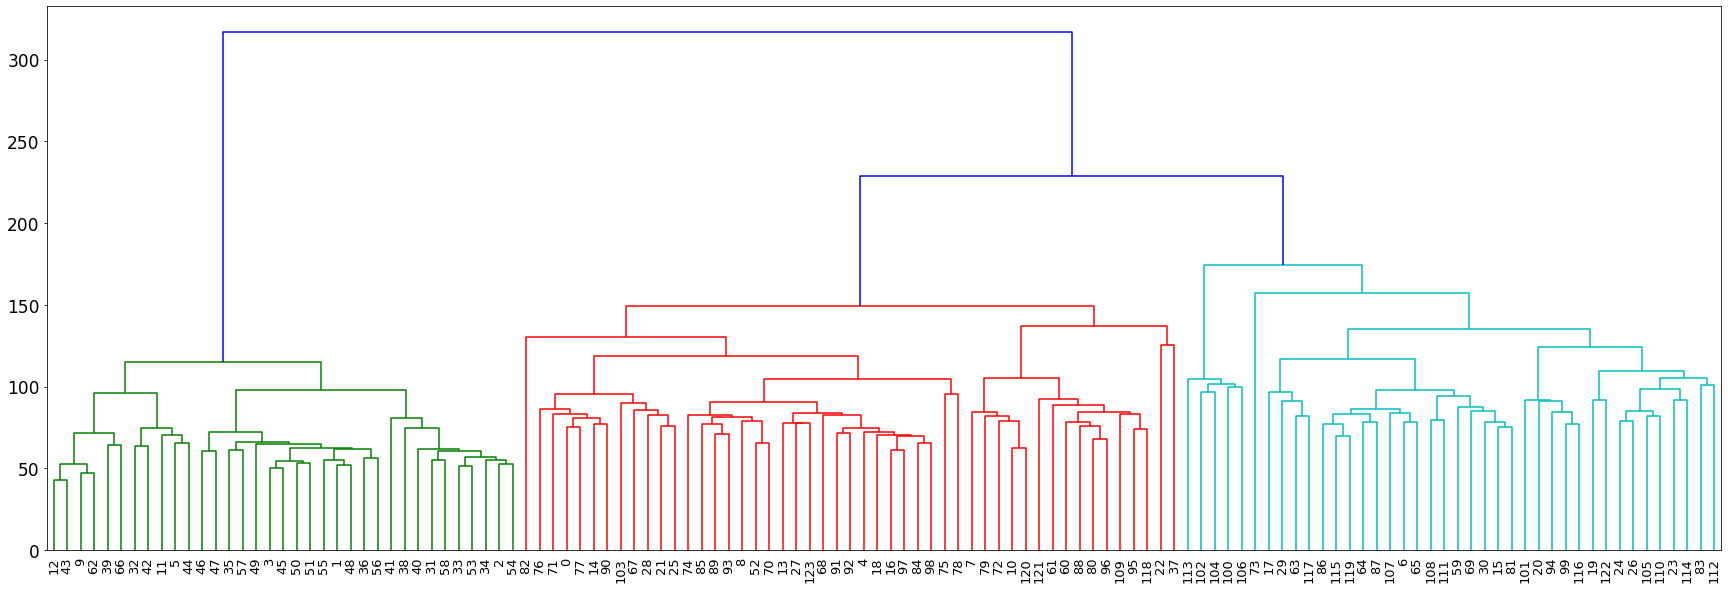

In [26]:
## Hierarchical Clustering

LF_matrix = np.load('./Data/LF/LF_e1500.npy')

from matplotlib.pyplot import cm
plt.figure(figsize=(30, 10))
# plt.grid()
linked = linkage(LF_matrix, method='ward', metric='euclidean')   # ward , single , complete , weighted, average , centroid
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)  # descending
cmap = cm.rainbow(np.linspace(0, 1, 2))
# hierarchy.set_link_color_palette([mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap])
# hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=13)
ax.tick_params(axis='y', which='major', labelsize=17)
plt.show()

In [27]:
## K-Means Clustering

LF_matrix = np.load('./Data/LF/LF_e1500.npy')

print(LF_matrix.shape, '\n')
kmeans = KMeans(n_clusters=4, random_state=0).fit(LF_matrix)
cluster_labels = kmeans.labels_
print(cluster_labels, '\n\n\n')

cluster_predict = kmeans.predict(LF_matrix[:])
# print(cluster_predict, '\n\n\n')

cluster_center = kmeans.cluster_centers_
# print(cluster_center.shape, '\n\n', cluster_center)

(124, 36864) 

[2 0 0 0 2 2 2 2 2 0 0 0 0 2 2 3 1 1 2 1 3 1 1 2 1 2 3 1 2 1 3 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 0 2 2 2 0 2 1 3 2 2 2 1
 2 2 2 2 2 2 2 2 3 1 2 2 1 2 2 2 2 2 2 1 3 2 2 2 1 3 3 3 3 2 3 1 3 1 1 2 1
 1 3 3 1 1 3 1 2 1 0 2 1 2] 





## LF_matrix as a DataFrame

In [28]:
## Define some variables

rows = []
val_name = sample_val_subset
train_name = sample_train_subset

In [29]:
## Refining sample names

# for p in range (len(val_name)):
#     Pat_name = val_name[:][p]
#     if Pat_name[7] == '_':
#         Pat_name = Pat_name[0:9]
#     elif Pat_name[6] == '_':
#         Pat_name = Pat_name[0:4] + '0' + Pat_name[4:8]
#     else:
#         Pat_name = Pat_name[0:4] + '00' + Pat_name[4:7]
#     rows.append([Pat_name])

# for p in range (len(train_name)):
#     Pat_name = train_name[:][p]
#     if Pat_name[7] == '_':
#         Pat_name = Pat_name[0:9]
#     elif Pat_name[6] == '_':
#         Pat_name = Pat_name[0:4] + '0' + Pat_name[4:8]
#     else:
#         Pat_name = Pat_name[0:4] + '00' + Pat_name[4:7]
#     rows.append([Pat_name])
# rows

In [30]:
## Considering different cluster-labels based on different epochs

# for p in range(124):
#     rows[p].append(cluster_labels[p])    # e300
#     rows[p].append(cluster_labels[p])    # e500
#     rows[p].append(cluster_labels[p])    # e1000
#     rows[p].append(cluster_labels[p])    # e1500
#     rows[p].append(0)    # difference
# rows

In [31]:
# ## Index and Column names of DataFrame

# df = pd.DataFrame(rows, columns=["Pat_name", "class_e300", "class_e500", "class_e1000", "class_e1500", "same_clusters"])
# # print(df)

In [32]:
# ## Engineering of DataFrame and saving

# df['class_e500'][df['class_e500'] == 2] = 7
# df['class_e500'][df['class_e500'] == 0] = 2
# df['class_e500'][df['class_e500'] == 7] = 0

# df['class_e1000'][df['class_e1000'] == 3] = 7
# df['class_e1000'][df['class_e1000'] == 0] = 3
# df['class_e1000'][df['class_e1000'] == 7] = 0

# df['class_e1500'][df['class_e1500'] == 2] = 7
# df['class_e1500'][df['class_e1500'] == 1] = 2
# df['class_e1500'][df['class_e1500'] == 7] = 1

# for r in range (124):
#     if ((df['class_e300'][r] == df['class_e500'][r]) and 
#         (df['class_e1000'][r] == df['class_e500'][r]) and 
#         (df['class_e1000'][r] == df['class_e1500'][r])):
#         df['same_clusters'][r] = 1
# print(df)

# df.index = df[df.columns[0]]
# df = df.drop(['Pat_name'], axis=1)
# df = df.sort_index()

# df.to_csv(r'./Data/Pat_Class.csv', index=False)
# df

In [287]:
## Loading DataFrame

df = pd.read_csv('./Data/Pat_Class.csv')

df.index = df[df.columns[0]]
df = df.drop(['ID'], axis=1)
# df = df.drop(['same_clusters'], axis=1)
print('There are {} patients with different clusters in different-epochs training!\n\n'.format(124 - df['same_clusters'].sum()))
df

There are 40 patients with different clusters in different-epochs training!




,class_e300,class_e500,class_e1000,class_e1500,same_clusters
ID,,,,,
Pat_001_1,1,1,0,1,0
Pat_002_1,2,0,0,2,0
Pat_003_1,2,1,1,3,0
Pat_004_1,0,0,0,0,1
Pat_005_1,1,1,1,1,1
...,...,...,...,...,...
Pat_141_1,0,0,0,0,1
Pat_142_1,0,0,0,0,1
Pat_143_1,0,0,0,0,1


## Scatter plot of K-means Clustering

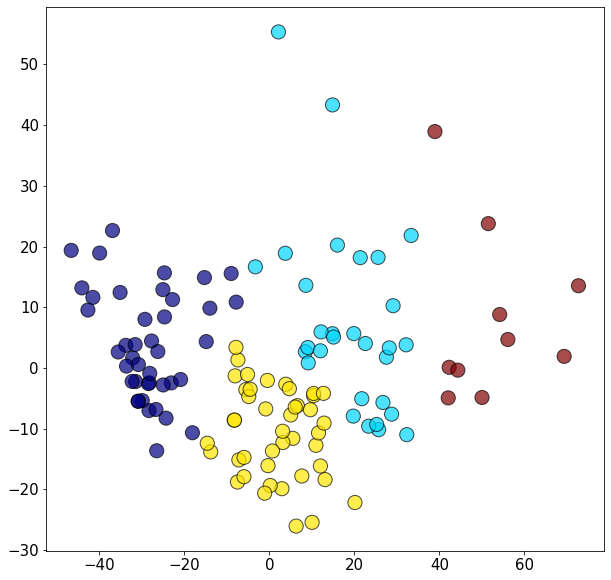

In [288]:
## PCA >>> Scatter plot >>> K-means Clustering

LF_matrix = np.load('./Data/LF/LF_e1500.npy')

## PCA analysis
pca = PCA(n_components=2)
pca.fit(LF_matrix)
LF_matrix_pca = pca.transform(LF_matrix)

## K-means of PCA
kmeans = KMeans(n_clusters=4)
kmeans.fit(LF_matrix_pca)
y_kmeans = kmeans.predict(LF_matrix_pca)

## Scatter Plot
plt.figure(figsize=(10, 10))
# plt.grid()
plt.scatter(LF_matrix_pca[:,0], LF_matrix_pca[:,1], c=y_kmeans, s=200, cmap='jet', edgecolors='k', alpha=0.7)
plt.gca().tick_params(axis='x', which='major', labelsize=15)
plt.gca().tick_params(axis='y', which='major', labelsize=15)
plt.show()

Estimated number of clusters: 3
Estimated number of noise points: 18
Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.916
Silhouette Coefficient: 0.626


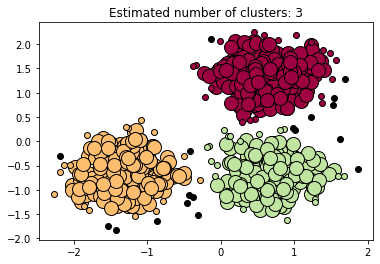

In [47]:
## DBSCAN Clustering

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4, random_state=0)
X = StandardScaler().fit_transform(X)
# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

## NeuroCognitive Data

In [1]:
# ## Loading original Neurocognitive score data

# score_df = pd.read_excel('./Data/Neurocognitive_Scores/Scores_original.xlsx')
# df = score_df
# for p in range (len(df)):
#     if df.ID[p][5] == '_': 
#         df.ID[p] = df.ID[p][0:4] + '00' + df.ID[p][4:]
#     elif df.ID[p][6] == '_': 
#         df.ID[p] = df.ID[p][0:4] + '0' + df.ID[p][4:]
# print('\033[1m There are totally {} records\n'.format(len(df)))

# ## Extract the Baseline_Phase and save
# df = df.rename(columns={'Phase Description':'Phase_Description', 'GIA SS':'GIA_SS', 'Proc Spd SS':'Proc_Spd_SS', 'Working Mem SS':'Working_Mem_SS', 'Broad Attn SS':'Broad_Attn_SS'})
# df.index = df[df.columns[0]]
# df = df.drop(['ID'], axis=1)
# df = df.drop(['Date'], axis=1)
# df_base = df[(df.Phase_Description == 'Baseline phase') | (df.Phase_Description == 'Baseline Phase')]
# df_base.Phase_Description = 'baseline_phase'
# print('\033[1m There are {} records of baseline_phasse\n'.format(len(df_base)))
# df_base.to_csv((r'./Data/Neurocognitive_Scores/baseline.csv'))

# ## Extract the 36_months_Phase and save
# df_36 = df[(df.Phase_Description == 'Post Dx 36 months')]# | (df.Phase_Description == 'Baseline Phase')]
# df_36.Phase_Description = '36_months'
# print('\033[1m There are {} records of 36_months\n'.format(len(df_36)))
# df_36.to_csv((r'./Data/Neurocognitive_Scores/m36.csv'))

In [4]:
## Developing Scores for Baseline

df_base = pd.read_csv('./Data/Neurocognitive_Scores/baseline.csv')
print('\033[1m There are {} records of Baseline_phase\n'.format(len(df_base)))
df_base.index = df_base.ID
# df_base

## Baseline_phasse & GIA_Score
df_base_GIA = df_base.GIA_SS
df_base_GIA = df_base_GIA.dropna()   # remove NaN
df_base_GIA = df_base_GIA.astype(int)
print('\033[1m Among {} records of Baseline_phasse,'.format(len(df_base)) , 'there are {} records for GIA_Score\n'.format(len(df_base_GIA)))
# df_base_GIA.to_csv((r'./Data/Neurocognitive_Scores/baseline_GIA.csv'))
# df_base_GIA

## Baseline_phasse & Process_Spead_Score
df_base_Proc_Spd = df_base.Proc_Spd_SS
df_base_Proc_Spd = df_base_Proc_Spd.dropna()   # remove NaN
df_base_Proc_Spd = df_base_Proc_Spd.astype(int)
print('\033[1m Among {} records of Baseline_phase,'.format(len(df_base)) , 'there are {} records for Process_Spead_Score\n'.format(len(df_base_Proc_Spd)))
# df_base_Proc_Spd.to_csv((r'./Data/Neurocognitive_Scores/baseline_Proc_Spd.csv'))
# df_base_Proc_Spd

## Baseline_phasse & Working_Memory_Score
df_base_Working_Mem = df_base.Working_Mem_SS
df_base_Working_Mem = df_base_Working_Mem.dropna()   # remove NaN
df_base_Working_Mem = df_base_Working_Mem.astype(int)
print('\033[1m Among {} records of Baseline_phase,'.format(len(df_base)) , 'there are {} records for Working_Memory_Score\n'.format(len(df_base_Working_Mem)))
# df_base_Working_Mem.to_csv((r'./Data/Neurocognitive_Scores/baseline_Working_Mem.csv'))
# df_base_Working_Mem

## Baseline_phasse & Broad_Attention_Score
df_base_Broad_Attn = df_base.Broad_Attn_SS
df_base_Broad_Attn = df_base_Broad_Attn.dropna()   # remove NaN
df_base_Broad_Attn = df_base_Broad_Attn.astype(int)
print('\033[1m Among {} records of Baseline_phase,'.format(len(df_base)) , 'there are {} records for Broad_Attention_Score\n'.format(len(df_base_Broad_Attn)))
# df_base_Broad_Attn.to_csv((r'./Data/Neurocognitive_Scores/baseline_Broad_Attn.csv'))
# df_base_Broad_Attn

 There are 82 records of Baseline_phasse

 Among 82 records of Baseline_phasse, there are 78 records for GIA_Score

 Among 82 records of Baseline_phasse, there are 74 records for Process_Spead_Score

 Among 82 records of Baseline_phasse, there are 74 records for Working_Memory_Score

 Among 82 records of Baseline_phasse, there are 66 records for Broad_Attention_Score



In [10]:
## Developing Scores for 36_Months

df_m36 = pd.read_csv('./Data/Neurocognitive_Scores/m36.csv')

print('\033[1m There are {} records for Month-36 \n'.format(len(df_m36)))
df_m36.index = df_m36.ID

## Month-36 & GIA_Score
df_m36_GIA = df_m36.GIA_SS
df_m36_GIA = df_m36_GIA.dropna()   # remove NaN
df_m36_GIA = df_m36_GIA.astype(int)
print('\033[1m Among {} records of Month-36,'.format(len(df_m36)) , 'there are {} records for GIA_Score\n'.format(len(df_m36_GIA)))
df_m36_GIA.to_csv((r'./Data/Neurocognitive_Scores/m36_GIA.csv'))

## Month-36 & Process_Spead_Score
df_m36_Proc_Spd = df_m36.Proc_Spd_SS
df_m36_Proc_Spd = df_m36_Proc_Spd.dropna()   # remove NaN
df_m36_Proc_Spd = df_m36_Proc_Spd.astype(int)
print('\033[1m Among {} records of Month-36,'.format(len(df_m36)) , 'there are {} records for Process_Spead_Score\n'.format(len(df_m36_Proc_Spd)))
df_m36_Proc_Spd.to_csv((r'./Data/Neurocognitive_Scores/m36_Proc_Spd.csv'))

## Month-36 & Working_Memory_Score
df_m36_Working_Mem = df_m36.Working_Mem_SS
df_m36_Working_Mem = df_m36_Working_Mem.dropna()   # remove NaN
df_m36_Working_Mem = df_m36_Working_Mem.astype(int)
print('\033[1m Among {} records of Month-36,'.format(len(df_m36)) , 'there are {} records for Working_Memory_Score\n'.format(len(df_m36_Working_Mem)))
df_m36_Working_Mem.to_csv((r'./Data/Neurocognitive_Scores/m36_Working_Mem.csv'))

## Month-36 & Broad_Attention_Score
df_m36_Broad_Attn = df_m36.Broad_Attn_SS
df_m36_Broad_Attn = df_m36_Broad_Attn.dropna()   # remove NaN
df_m36_Broad_Attn = df_m36_Broad_Attn.astype(int)
print('\033[1m Among {} records of Month-36,'.format(len(df_m36)) , 'there are {} records for Broad_Attention_Score\n'.format(len(df_m36_Broad_Attn)))
df_m36_Broad_Attn.to_csv((r'./Data/Neurocognitive_Scores/m36_Broad_Attn.csv'))

 There are 80 records for Month-36 

 Among 80 records of Month-36, there are 79 records for GIA_Score

 Among 80 records of Month-36, there are 78 records for Process_Spead_Score

 Among 80 records of Month-36, there are 78 records for Working_Memory_Score

 Among 82 records of Month-36, there are 75 records for Broad_Attention_Score



In [30]:
## Developing Scores for (36_Months - Baseline_Phase)

## m36_b & GIA_Score
df_base_GIA = pd.read_csv('./Data/Neurocognitive_Scores/baseline_GIA.csv')
df_m36_GIA = pd.read_csv('./Data/Neurocognitive_Scores/m36_GIA.csv')
# print(df_m36_GIA)
# print(df_base_GIA)
df_m36_join_base_GIA = pd.merge(df_m36_GIA, df_base_GIA, how='inner', on=['ID'])
df_m36_join_base_GIA['GIA_SS'] = df_m36_join_base_GIA.GIA_SS_x - df_m36_join_base_GIA.GIA_SS_y 
print('\033[1m Among {} records of Month-36,'.format(len(df_m36)) , 'and {} records of baseline,'.format(len(df_base)) ,
      'there are {} common records for GIA_Score\n'.format(len(df_m36_join_base_GIA)))
# print(df_m36_join_base_GIA)
df_m36_base_GIA = df_m36_join_base_GIA.drop(['GIA_SS_x', 'GIA_SS_y'], axis=1)

df_m36_base_GIA.to_csv((r'./Data/Neurocognitive_Scores/m36_base_GIA.csv'))
# df_m36_base_GIA

 Among 80 records of Month-36, and 82 records of baseline, there are 58 common records for GIA_Score



## Joining